In [166]:
import math
import random
import time

import sklearn.metrics
from numpy import arange, c_
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import PolynomialFeatures
from sklearn.svm import SVC
from sklearn import datasets

import scipy
from scipy import optimize

import numpy as np

from sklearn.metrics import confusion_matrix, accuracy_score, ConfusionMatrixDisplay, RocCurveDisplay, roc_curve

import matplotlib.pyplot as plt

import pandas as pd



noise = 16
samples = 2425
seed = 244825
classes = 2
train_split = 0.8
test_split = 0.2
repeats = 100

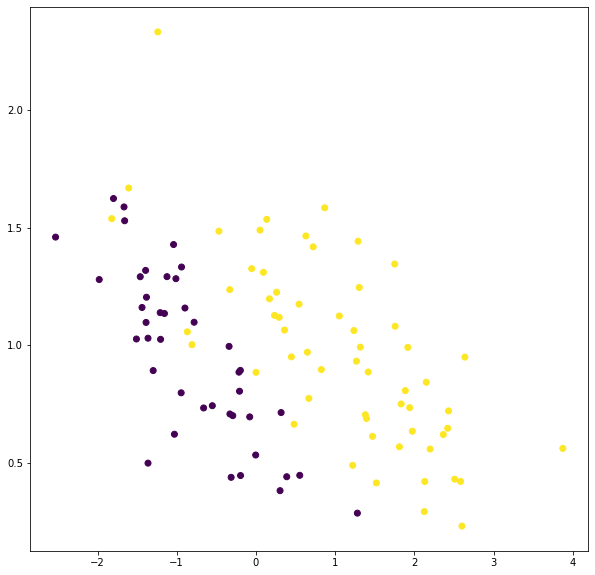

In [167]:
X, y = datasets.make_classification(n_features=2, random_state=seed, n_redundant=0, n_samples=samples, n_classes=2, n_clusters_per_class=1)

y[y == 0] = -1

X_train, X_test, y_train, y_test = train_test_split(X, y, train_size=100, test_size=test_split, random_state=seed)

xx, yy = np.meshgrid(np.arange(X.min(), X.max(), 0.01),
                       np.arange(X.min(), X.max(), 0.01))

plt.figure(figsize=(10,10))
plt.scatter(X_train[:, 0], X_train[:, 1], c=y_train)

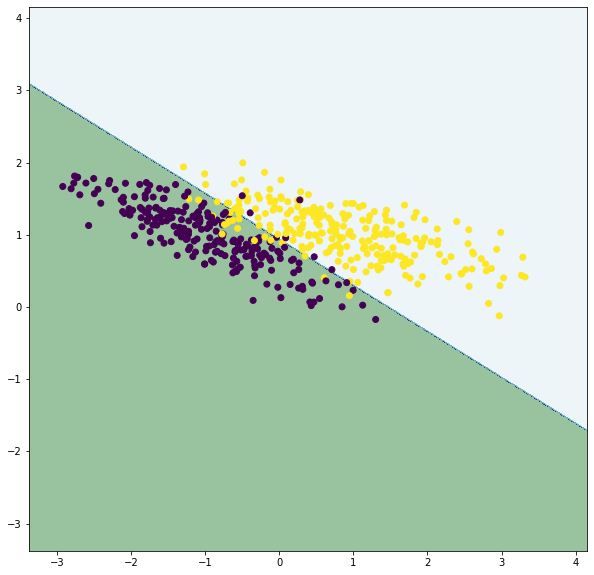

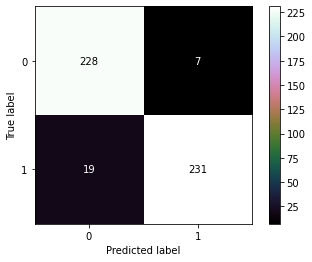

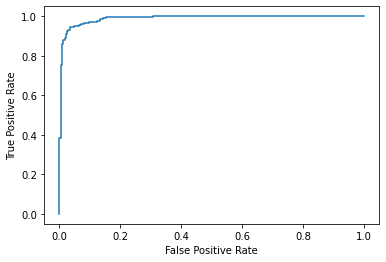

In [168]:
model = SVC(kernel='linear')

time_sk = time.perf_counter()
model.fit(X_train, y_train)
time_sk = time.perf_counter() - time_sk
predict1 = model.predict(X_test)
#predict1 = [-1 if x == 0 else 1 for x in predict1]

confusion_matrix(y_test, predict1)

mesh_data = c_[xx.ravel(), yy.ravel()]

predict = model.predict(mesh_data)
predict = predict.reshape(xx.shape)
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, predict, alpha=0.4, cmap='ocean')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

cm_model = confusion_matrix(y_test, model.predict(X_test))
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, model.decision_function(X_test))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

In [169]:
# C = 0.01
# gamma = np.full(X_train.shape[0], 30)
#
# w = np.ones(X_train.shape[1])
# b = np.ones(X_train.shape[0])
#
# # X_train = np.column_stack((X_train, np.ones(X_train.shape[0])))
# def delta_cost(w):
#     return (1/2) * (w.T @ w)
#
# def cost_function(w):
#     w = np.asarray(w)
#     front = (1/2) * (w.T @ w)
#     ans = []
#     for i in range(X_train.shape[0]):
#         ans.append(
#             gamma[i] * (y_train[i] * (w.T @ X_train[i] + b[i]) - 1)
#         )
#     return front - sum(ans)
#
#
# def delta_w(X_param, y_param):
#     dlt = []
#     for i in range(X_param.shape[0]):
#         dlt.append(gamma[i] * y_param[i] * X_param[i].T)
#     return np.sum(dlt, axis=0)
#
#
# def predict_mine(X_param, w):
#     return np.asarray([0 if x<=0 else 1 for x in w @ X_param.T])
#
# def compute_cost(W):
#     # calculate hinge loss
#     N = X_train.shape[0]
#     distances = 1 - y_train * (np.dot(X_train, W))
#     distances[distances < 0] = 0  # equivalent to max(0, distance)
#     hinge_loss = C * (np.sum(distances) / N)
#
#     # calculate cost
#     cost = 1 / 2 * np.dot(W, W) + hinge_loss
#     return cost
#
# print(compute_cost((1, 1)), cost_function((1, 1)))
#
# w = scipy.optimize.minimize(cost_function, (1, 1)).x
# w
#
# predict_own_1 = predict_mine(X_test, w)
# # predict_own_1 = [0 if x<=0 else 1 for x in predict_own_1]
#
# predict_own = predict_mine(mesh_data, w)
# predict_own = predict_own.reshape(xx.shape)
# plt.figure(figsize=(10, 10))
# plt.contourf(xx, yy, predict_own, alpha=0.4, cmap='ocean')
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
#
# cm_model = confusion_matrix(y_test, predict_own_1)
# tn_model = cm_model[0][0]
# fn_model = cm_model[0][1]
# tp_model = cm_model[1][1]
# fp_model = cm_model[1][0]
# ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')
#
# fpr, tpr, roc_auc = roc_curve(y_test, w @ X_test.T)
#
# rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
# rok_model.plot()

In [170]:
from scipy.optimize import LinearConstraint, Bounds, minimize

ZERO = 1e-5

class MySVM:
    _sparse_kernels = ['linear', 'poly', 'rbf']

    @staticmethod
    def _linear_kernel(x1, x2, *args):
        return np.dot(x1, x2)

    @staticmethod
    def _poly_kernel(x1, x2, *args): # args[0] - degree, args[1] - gamma, args[2] - intercept
        return (args[1] * np.dot(x1, x2) + args[2]) ** args[0]

    @staticmethod
    def _rbf_kernel(x1, x2, *args):  # args[0] - degree, args[1] - gamma, args[2] - intercept
        return np.exp(-args[1] * np.linalg.norm(x1 - x2) ** 2)

    def __init__(self, C=1, kernel='rbf', gamma=0.1, degree=2, random_state=244827):
        if kernel not in self._sparse_kernels:
            raise ValueError(f'kernel {kernel} is not supported')
        self.C = C
        self.kernel = kernel
        self.gamma = gamma
        self.degree = degree
        self.random_state = random_state
        self.kernel_function = {'linear': self._linear_kernel, 'poly': self._poly_kernel, 'rbf': self._rbf_kernel}[kernel]
        self.coef_ = None
        self.intercept_ = None
        self.alpha_ = None
        self.support_ = None
        self.support_vectors_ = None
        self.support_labels = None
        self.train_labels = None
        self.train_vectors_ = None

    def _lagrange_function(self, alpha, x, y2):
        res = 0
        for i in range(alpha.shape[0]):
            for j in range(alpha.shape[0]):
                res += alpha[i] * alpha[j] * y2[i] * y2[j] * self.kernel_function(x[i], x[j], self.degree, self.gamma, 0)

        return  0.5 * res - sum(alpha)

    def fit(self, x_train, y_train2):
        n, m = x_train.shape
        # np.random.seed(self.random_state)
        alpha_start = np.random.uniform(0, self.C, size=n)
        # alpha_start = np.zeros(n)
        linear_constraint = LinearConstraint(A=y_train2, lb=[0], ub=[0])
        bounds = Bounds(np.zeros(n), np.full(n, self.C-ZERO))
        result = minimize(
            fun=self._lagrange_function,
            x0=alpha_start,
            args=(x_train, y_train2),
            # hess=BFGS(),
            constraints=[linear_constraint],
            bounds=bounds)
        self.alpha_ = result.x
        self.alpha_[self.alpha_ < ZERO] = 0
        self.support_ = np.where(self.alpha_ > ZERO)[0]
        self.support_vectors_ = x_train[self.support_]
        self.support_labels = y_train2[self.support_]
        self.train_vectors_ = x_train
        self.train_labels = y_train2

        self.coef_ = np.zeros(m)
        for i in self.support_:
            self.coef_ += self.alpha_[i] * y_train2[i] * x_train[i]

        self.intercept_ = 0
        # c_num = self.C - ZERO
        for i in self.support_:
            self.intercept_ += y_train2[i] - np.dot(self.coef_, x_train[i])
        self.intercept_ /= len(self.support_)
        print(self.coef_, self.intercept_)
        return self

    def decision_function(self, x):
        if self.coef_ is None or self.intercept_ is None:
            raise ValueError('Model is not fitted yet')

        if self.kernel == 'linear':
            return np.dot(x, self.coef_) + self.intercept_

        y_pred = []
        for sample in x:
            pred = 0
            for i in self.support_:
                pred += self.alpha_[i] * self.train_labels[i] * self.kernel_function(sample, self.train_vectors_[i, :], self.degree, self.gamma, self.intercept_)
            y_pred.append(pred)

        return np.array(y_pred)

    def predict(self, x):
        if self.coef_ is None or self.intercept_ is None:
            raise ValueError('Model is not fitted yet')
        return np.sign(self.decision_function(x))

[1.74587361 2.73609672] -2.3794750314851387


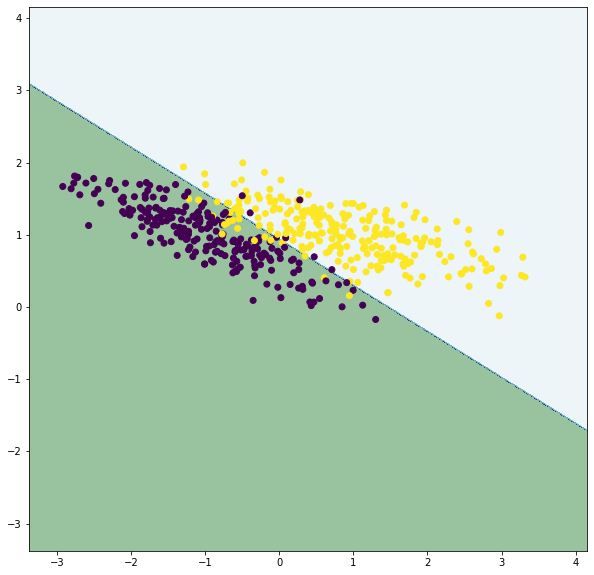

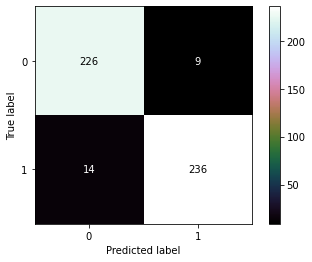

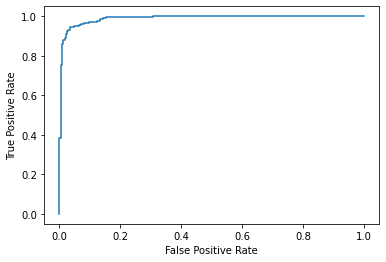

In [171]:
mdl = MySVM(kernel='linear', degree=2)


mdl.fit(X_train, y_train)
pred1 = mdl.predict(X_test)

mesh_data = c_[xx.ravel(), yy.ravel()]

predict = model.predict(mesh_data)
predict = predict.reshape(xx.shape)
plt.figure(figsize=(10, 10))
plt.contourf(xx, yy, predict, alpha=0.4, cmap='ocean')
plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)

cm_model = confusion_matrix(y_test, pred1, labels=[-1, 1])
tn_model = cm_model[0][0]
fn_model = cm_model[0][1]
tp_model = cm_model[1][1]
fp_model = cm_model[1][0]
ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')

fpr, tpr, roc_auc = roc_curve(y_test, mdl.decision_function(X_test))

rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
rok_model.plot()

In [172]:
# model = SVM(X_train, y_train, 10000, 1e-3, 30)
#
# time_sk = time.perf_counter()
# model.fit()
# time_sk = time.perf_counter() - time_sk
# predict1 = model.predict(X_test)
# # predict1 = [np.sign(x) for x in predict1]
#
# confusion_matrix(y_test, predict1)
#
# mesh_data = c_[xx.ravel(), yy.ravel()]
#
# predict = model.predict(mesh_data)
# predict = predict.reshape(xx.shape)
# plt.figure(figsize=(10, 10))
# plt.contourf(xx, yy, predict, alpha=0.4, cmap='ocean')
# plt.scatter(X_test[:, 0], X_test[:, 1], c=y_test)
#
# cm_model = confusion_matrix(y_test, predict1)
# tn_model = cm_model[0][0]
# fn_model = cm_model[0][1]
# tp_model = cm_model[1][1]
# fp_model = cm_model[1][0]
# ConfusionMatrixDisplay(cm_model).plot(cmap='cubehelix')
#
# fpr, tpr, roc_auc = roc_curve(y_test, predict1)
#
# rok_model = RocCurveDisplay(fpr=fpr, tpr=tpr)
# rok_model.plot()
# print(predict1)